### Explore the training set

https://www.kaggle.com/c/home-credit-default-risk

Ad-hoc exploration of `application_train.csv` dataset to find numeric and categorical variables

In [1]:
%matplotlib inline

In [122]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
import glob
import shutil
import json

In [45]:
outputdir = "/Users/telvis/notebooks/kaggle_credit_risk/output"

In [4]:
train_df = pd.read_csv('./data/application_train.csv')
print("shape",train_df.shape)
print("columns",train_df.columns)

shape (307511, 122)
columns Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [5]:
train_df["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

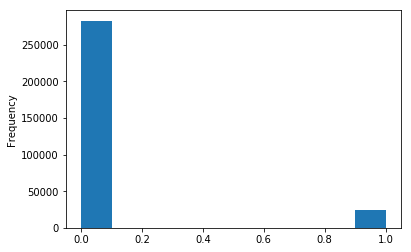

In [6]:
train_df['TARGET'].astype(int).plot.hist();

## Missing Values

In [12]:
all_counts = train_df.shape[0]
null_counts_dict = train_df.isnull().sum().to_dict()

In [17]:
rows = []
for colname, null_count in null_counts_dict.items():
    if null_count > 0:
        rows.append({"colname": colname, "null_count": null_count})
        
null_count_df = pd.DataFrame(rows)
null_count_df["percent_null"] = null_count_df["null_count"].apply(lambda x : float(x) / all_counts)
display(null_count_df.sort_values("null_count", ascending=False).head(20))

,colname,null_count,percent_null
41,COMMONAREA_MEDI,214865,0.698723
13,COMMONAREA_AVG,214865,0.698723
27,COMMONAREA_MODE,214865,0.698723
49,NONLIVINGAPARTMENTS_MEDI,213514,0.694330
35,NONLIVINGAPARTMENTS_MODE,213514,0.694330
21,NONLIVINGAPARTMENTS_AVG,213514,0.694330
51,FONDKAPREMONT_MODE,210295,0.683862
33,LIVINGAPARTMENTS_MODE,210199,0.683550
47,LIVINGAPARTMENTS_MEDI,210199,0.683550
19,LIVINGAPARTMENTS_AVG,210199,0.683550


## Column Types

In [19]:
train_df.dtypes.value_counts()


float64    65
int64      41
object     16
dtype: int64

In [25]:
# Number of unique classes in each object column
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [76]:
# clean nulls
col_has_nulls = train_df.isna().any()
null_col_names =  train_df.columns[col_has_nulls].tolist()
null_col_dtypes = train_df.dtypes[col_has_nulls].tolist()

null_cols = [r for r in zip(null_col_names, null_col_dtypes)]



In [96]:
def show_null_value_cols(df):
    # clean nulls
    col_has_nulls = df.isna().any()
    null_col_names =  df.columns[col_has_nulls].tolist()
    null_col_dtypes = df.dtypes[col_has_nulls].tolist()
    null_cols = [r for r in zip(null_col_names, null_col_dtypes)]

    # list the null cols
    for colname, coltype in null_cols:
        print ("*"*10)
        if coltype == "float64":
            print (colname, "float")
            print ("\t mean()", df[colname].mean())
        elif coltype == 'object':
            vals = list(df[colname].unique())
            print (colname, "object")
            print ("\t", vals)

        print ("")
        
    return null_cols


def fix_null_values(df, null_cols):
    # list the null cols
    for colname, coltype in null_cols:
        print ("*"*10)
        if coltype == "float64":
            print (colname, "float")
            val = df[colname].mean()
            df[colname].fillna(val, inplace=True)
        elif coltype == 'object':
            print (colname, "object")
            df[colname].fillna("UNKNOWN", inplace=True)
        else:
            raise RuntimeError("Unknow type: {}".format(coltype))

        print ("")
    
    null_cols = show_null_value_cols(df=train_df)
    
def do_data_cleaning(input_csv, output_csv):
    print("Reading", input_csv)
    df = pd.read_csv(input_csv)
    
    print("Find null columns")
    null_cols = show_null_value_cols(df=df)
    fix_null_values(df=df, null_cols=null_cols)
    
    print("Sanity check")
    null_cols = show_null_value_cols(df=train_df)
    assert len(null_cols) == 0
    print("Sanity check passed")
    
    print("Write to", output_csv)
    train_df.to_csv(output_csv, index=False)
    print("do_data_cleaning - done")



In [97]:
input_csv =  './data/application_train.csv'
output_csv = os.path.join(outputdir, 'application_train.clean.csv')
do_data_cleaning(input_csv=input_csv, output_csv=output_csv)

Reading ./data/application_train.csv
Find null columns
**********
AMT_ANNUITY float
	 mean() 27108.573909183444

**********
AMT_GOODS_PRICE float
	 mean() 538396.2074288895

**********
NAME_TYPE_SUITE object
	 ['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', nan, 'Other_B', 'Group of people']

**********
OWN_CAR_AGE float
	 mean() 12.061090818687727

**********
OCCUPATION_TYPE object
	 ['Laborers', 'Core staff', 'Accountants', 'Managers', nan, 'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff', 'Private service staff', 'Medicine staff', 'Security staff', 'High skill tech staff', 'Waiters/barmen staff', 'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff']

**********
CNT_FAM_MEMBERS float
	 mean() 2.152665450442101

**********
EXT_SOURCE_1 float
	 mean() 0.5021298056566625

**********
EXT_SOURCE_2 float
	 mean() 0.5143926741308462

**********
EXT_SOURCE_3 float
	 mean() 0.5108529061799658

**********
APARTMENTS_AVG float
	 mean() 0.

In [98]:
input_csv =  './data/application_test.csv'
output_csv = os.path.join(outputdir, 'application_test.clean.csv')
do_data_cleaning(input_csv=input_csv, output_csv=output_csv)

Reading ./data/application_test.csv
Find null columns
**********
AMT_ANNUITY float
	 mean() 29426.240209359607

**********
NAME_TYPE_SUITE object
	 ['Unaccompanied', nan, 'Family', 'Spouse, partner', 'Group of people', 'Other_B', 'Children', 'Other_A']

**********
OWN_CAR_AGE float
	 mean() 11.786027263875365

**********
OCCUPATION_TYPE object
	 [nan, 'Low-skill Laborers', 'Drivers', 'Sales staff', 'High skill tech staff', 'Core staff', 'Laborers', 'Managers', 'Accountants', 'Medicine staff', 'Security staff', 'Private service staff', 'Secretaries', 'Cleaning staff', 'Cooking staff', 'HR staff', 'Waiters/barmen staff', 'Realty agents', 'IT staff']

**********
EXT_SOURCE_1 float
	 mean() 0.501179810639628

**********
EXT_SOURCE_2 float
	 mean() 0.5180210756705393

**********
EXT_SOURCE_3 float
	 mean() 0.5001056254095524

**********
APARTMENTS_AVG float
	 mean() 0.12238773786056242

**********
BASEMENTAREA_AVG float
	 mean() 0.09006548358053357

**********
YEARS_BEGINEXPLUATATION_AVG fl

In [100]:
# fix_null_values(df=train_df, null_cols=null_cols)

In [99]:
# should show no NULLs
# null_cols = show_null_value_cols(df=train_df)

In [101]:
output_fn = os.path.join(outputdir, 'application_train.clean.csv')
train_df = pd.read_csv(output_fn)


In [21]:
## TODO: One-hot encoding of the categorical cols

In [102]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [103]:
def generate_encoders(df):
    # TODO: save a pickled encoder.

    one_hot_encoders_di = {}
    label_encoders_di = {}
    object_cols = df.select_dtypes('object').apply(pd.Series.nunique, axis = 0).to_dict()
    for colname, num_unique in object_cols.items():        
        vals = list(train_df[colname].unique())
        

        if num_unique > 2: 
    #         print ("onehot:",colname,":",vals)
            vals_ = np.array(vals).reshape(-1, 1)
            enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
            enc.fit(vals_)
            one_hot_encoders_di[colname] = {'encoder': enc,
                                            'colnames': ["onehot__{}_{}".format(colname, i) for i in range(num_unique)]}
            print ("onehot:",colname,":",enc.categories_)
        else:
            enc = LabelEncoder()
            enc.fit(vals)
            label_encoders_di[colname] = {'encoder': enc, 
                                          'colnames': ["label__{}".format(colname)]}
            print ("label:",colname,":",enc.classes_)
                                            
    return one_hot_encoders_di, label_encoders_di
      
        

In [104]:
one_hot_encoders_di, label_encoders_di = generate_encoders(df=train_df)  

label: NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']
onehot: CODE_GENDER : [array(['F', 'M', 'XNA'], dtype='<U3')]
label: FLAG_OWN_CAR : ['N' 'Y']
label: FLAG_OWN_REALTY : ['N' 'Y']
onehot: NAME_TYPE_SUITE : [array(['Children', 'Family', 'Group of people', 'Other_A', 'Other_B',
       'Spouse, partner', 'UNKNOWN', 'Unaccompanied'], dtype='<U15')]
onehot: NAME_INCOME_TYPE : [array(['Businessman', 'Commercial associate', 'Maternity leave',
       'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working'],
      dtype='<U20')]
onehot: NAME_EDUCATION_TYPE : [array(['Academic degree', 'Higher education', 'Incomplete higher',
       'Lower secondary', 'Secondary / secondary special'], dtype='<U29')]
onehot: NAME_FAMILY_STATUS : [array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
       'Unknown', 'Widow'], dtype='<U20')]
onehot: NAME_HOUSING_TYPE : [array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
       'Office apartment', 'Rented ap

In [155]:
def add_onehot_col(df, one_hot_encoders_di, output_feat_dir, idxcol="SK_ID_CURR", drop=True):
    df.set_index(idxcol, drop=False, inplace=True)
    
    for colname in one_hot_encoders_di:
        output_csv_gz = os.path.join(output_feat_dir, "onehot__colname__{}.csv.gz".format(colname))
        if os.path.isfile(output_csv_gz):
            print("[add_onehot_col] - skipping: {}".format(colname))
            continue
        
        print("[add_onehot_col] - adding: {}".format(colname))
        enc = one_hot_encoders_di[colname]["encoder"]
        colnames = one_hot_encoders_di[colname]["colnames"]
        values = df[colname].values
        
        print(colname, "values.shape", values.shape)
        onehot_values = enc.transform(values.reshape(-1, 1))
        
        print(colname, "onehot_values.shape", onehot_values.shape)
        
        # write the onehot values to disk
        onehot_df = pd.DataFrame(onehot_values, columns=colnames,
                                 index=df.index)
        onehot_df.index.name = idxcol
        onehot_df[colname] = values
        onehot_df.to_csv(output_csv_gz, compression="gzip", index=False)
#         column_names = onehot_df.columns.tolist()
#         print(json.dumps(sorted(column_names), indent=2))
        
        print("drop",colname,type(colname))
        onehot_df = onehot_df.drop(colname, axis=1)
        
        print("Wrote to", output_csv_gz)
        print("")
        
        onehot_df = pd.concat([df, onehot_df], axis=1, copy=False)
        if drop:
            onehot_df = onehot_df.drop(colname, axis=1)
#         column_names = onehot_df.columns.tolist()
#         print(json.dumps(sorted(column_names), indent=2))
#         break

        
    return onehot_df


def add_label_col(df, label_encoders_di, output_feat_dir, idxcol="SK_ID_CURR", drop=True):
    df.set_index(idxcol, drop=False, inplace=True)
    
    for colname in label_encoders_di:
        output_csv_gz = os.path.join(output_feat_dir, "label__colname__{}.csv.gz".format(colname))
        if os.path.isfile(output_csv_gz):
            print("[add_label_col] - skipping: {}".format(colname))
            continue
        
        print("[add_label_col] - adding: {}".format(colname))
        enc = label_encoders_di[colname]["encoder"]
        colnames = label_encoders_di[colname]["colnames"]
        values = df[colname].values
        
        print(colname, "values.shape", values.shape)
#         label_values = enc.transform(values.reshape(-1, 1))
        label_values = enc.transform(values)

        
        print(colname, "onehot_values.shape", label_values.shape)
        
        # write the onehot values to disk
        label_df = pd.DataFrame(label_values, columns=colnames,
                                 index=df.index)
        label_df.index.name = idxcol
        label_df[colname] = values
        label_df.to_csv(output_csv_gz, compression="gzip", index=False)
        
        print("drop",colname,type(colname))
        label_df = label_df.drop(colname, axis=1)
        
        print("Wrote to", output_csv_gz)
        print("")
        
        label_df = pd.concat([df, label_df], axis=1, copy=False)
        if drop:
            label_df = label_df.drop(colname, axis=1)
       
    return label_df

In [158]:
input_clean_csv = os.path.join(outputdir, 'application_train.clean.csv')
train_df = pd.read_csv(input_clean_csv)

output_features_dir = os.path.join(outputdir, "application_train_features")

if os.path.isdir(output_features_dir):
    shutil.rmtree(output_features_dir)
    
os.makedirs(output_features_dir)

onehot_df = add_onehot_col(df=train_df, one_hot_encoders_di=one_hot_encoders_di, 
               idxcol="SK_ID_CURR", output_feat_dir=output_features_dir, drop=True)

onehot_df = add_label_col(df=onehot_df, label_encoders_di=label_encoders_di, 
               idxcol="SK_ID_CURR", output_feat_dir=output_features_dir, drop=True)

fn = os.path.join(output_features_dir, 'application_train.csv.gz')
onehot_df.to_csv(fn, compression='gzip', index=False)
print ("Wrote to",fn)


[add_onehot_col] - adding: CODE_GENDER
CODE_GENDER values.shape (307511,)
CODE_GENDER onehot_values.shape (307511, 3)
drop CODE_GENDER <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/onehot__colname__CODE_GENDER.csv.gz
[add_onehot_col] - adding: NAME_TYPE_SUITE
NAME_TYPE_SUITE values.shape (307511,)
NAME_TYPE_SUITE onehot_values.shape (307511, 8)
drop NAME_TYPE_SUITE <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/onehot__colname__NAME_TYPE_SUITE.csv.gz
[add_onehot_col] - adding: NAME_INCOME_TYPE
NAME_INCOME_TYPE values.shape (307511,)
NAME_INCOME_TYPE onehot_values.shape (307511, 8)
drop NAME_INCOME_TYPE <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/onehot__colname__NAME_INCOME_TYPE.csv.gz
[add_onehot_col] - adding: NAME_EDUCATION_TYPE
NAME_EDUCATION_TYPE values.shape (307511,)
NAME_EDUCATION_TYPE onehot_values.shape (307511, 5)


/Users/telvis/virtualenvs/home_credit/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


drop NAME_CONTRACT_TYPE <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/label__colname__NAME_CONTRACT_TYPE.csv.gz
[add_label_col] - adding: FLAG_OWN_CAR
FLAG_OWN_CAR values.shape (307511,)
FLAG_OWN_CAR onehot_values.shape (307511,)
drop FLAG_OWN_CAR <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/label__colname__FLAG_OWN_CAR.csv.gz
[add_label_col] - adding: FLAG_OWN_REALTY
FLAG_OWN_REALTY values.shape (307511,)
FLAG_OWN_REALTY onehot_values.shape (307511,)
drop FLAG_OWN_REALTY <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/label__colname__FLAG_OWN_REALTY.csv.gz
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features/application_train.csv.gz


In [152]:
# def add_label_col(df, label_encoders_di, output_feat_dir, idxcol="SK_ID_CURR", drop=True):
#     df.set_index(idxcol, drop=False, inplace=True)
    
#     for colname in label_encoders_di:
#         output_csv_gz = os.path.join(output_feat_dir, "label__colname__{}.csv.gz".format(colname))
#         if os.path.isfile(output_csv_gz):
#             print("[add_label_col] - skipping: {}".format(colname))
#             continue
        
#         print("[add_label_col] - adding: {}".format(colname))
#         enc = label_encoders_di[colname]["encoder"]
#         colnames = label_encoders_di[colname]["colnames"]
#         values = df[colname].values
        
#         print(colname, "values.shape", values.shape)
#         label_values = enc.transform(values.reshape(-1, 1))
        
#         print(colname, "onehot_values.shape", label_values.shape)
        
#         # write the onehot values to disk
#         label_df = pd.DataFrame(label_values, columns=colnames,
#                                  index=df.index)
#         label_df.index.name = idxcol
#         label_df[colname] = values
#         label_df.to_csv(output_csv_gz, compression="gzip", index=False)
# #         column_names = onehot_df.columns.tolist()
# #         print(json.dumps(sorted(column_names), indent=2))
        
#         print("drop",colname,type(colname))
#         label_df = label_df.drop(colname, axis=1)
        
#         print("Wrote to", output_csv_gz)
        
#         label_df = pd.concat([df, label_df], axis=1, copy=False)
#         if drop:
#             label_df = label_df.drop(colname, axis=1)
# #         column_names = onehot_df.columns.tolist()
# #         print(json.dumps(sorted(column_names), indent=2))
# #         break

        
#     return label_df

In [153]:
input_clean_csv = os.path.join(outputdir, 'application_train.clean.csv')
train_df = pd.read_csv(input_clean_csv)

output_features_dir = os.path.join(outputdir, "application_train_features.label")
if os.path.isdir(output_features_dir):
    shutil.rmtree(output_features_dir)
    
os.makedirs(output_features_dir)

onehot_df = add_label_col(df=train_df, label_encoders_di=label_encoders_di, 
               idxcol="SK_ID_CURR", output_feat_dir=output_features_dir, drop=True)

fn = os.path.join(output_features_dir, 'application_train.labels.csv.gz')
onehot_df.to_csv(fn, compression='gzip', index=False)
print ("Wrote to",fn)

[add_label_col] - adding: NAME_CONTRACT_TYPE
NAME_CONTRACT_TYPE values.shape (307511,)
NAME_CONTRACT_TYPE onehot_values.shape (307511,)
drop NAME_CONTRACT_TYPE <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features.label/label__colname__NAME_CONTRACT_TYPE.csv.gz
[add_label_col] - adding: FLAG_OWN_CAR
FLAG_OWN_CAR values.shape (307511,)
FLAG_OWN_CAR onehot_values.shape (307511,)
drop FLAG_OWN_CAR <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features.label/label__colname__FLAG_OWN_CAR.csv.gz
[add_label_col] - adding: FLAG_OWN_REALTY
FLAG_OWN_REALTY values.shape (307511,)
FLAG_OWN_REALTY onehot_values.shape (307511,)
drop FLAG_OWN_REALTY <class 'str'>
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features.label/label__colname__FLAG_OWN_REALTY.csv.gz
Wrote to /Users/telvis/notebooks/kaggle_credit_risk/output/application_train_features.label/application_train.labels.csv.